IMPORT LIBRARY

In [ ]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

MENYIAPKAN DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7"
!chmod 600 /content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7
Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 99% 1.97G/1.98G [00:16<00:00, 160MB/s]
100% 1.98G/1.98G [00:16<00:00, 128MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip

Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  
  inflati

In [ ]:
base_path = "Fruit and Vegetable Image Recognition"
output_path = "dataset"

train_src = os.path.join(base_path, "train")
val_src   = os.path.join(base_path, "validation")
test_src  = os.path.join(base_path, "test")

train_dst = os.path.join(output_path, "train")
val_dst   = os.path.join(output_path, "validation")
test_dst  = os.path.join(output_path, "test")

os.makedirs(train_dst, exist_ok=True)
os.makedirs(val_dst, exist_ok=True)
os.makedirs(test_dst, exist_ok=True)

selected_fruits = [
    "banana",
    "apple",
    "pear",
    "grapes",
    "orange",
    "kiwi",
    "watermelon",
    "pomegranate",
    "pineapple",
    "mango"
]

for cls in selected_fruits:
    shutil.copytree(os.path.join(train_src, cls),
                    os.path.join(train_dst, cls))
    shutil.copytree(os.path.join(val_src, cls),
                    os.path.join(val_dst, cls))
    shutil.copytree(os.path.join(test_src, cls),
                    os.path.join(test_dst, cls))

print("Dataset buah saja berhasil disiapkan")


Dataset buah saja berhasil disiapkan


In [ ]:
print("Train      :", os.listdir("dataset/train"))
print("Validation :", os.listdir("dataset/validation"))
print("Test       :", os.listdir("dataset/test"))

Train      : ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Validation : ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Test       : ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']


KONFIGURASI

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

TRAIN_DIR = "/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/dataset/train"
VAL_DIR   = "/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/dataset/validation"
TEST_DIR  = "/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/dataset/test"

DATA GENERATOR

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
print("Jumlah kelas:", NUM_CLASSES)

Found 837 images belonging to 10 classes.
Found 97 images belonging to 10 classes.
Found 99 images belonging to 10 classes.
Jumlah kelas: 10


MODEL MOBILENETV2

In [ ]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

TRAINING

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 6/27 ━━━━━━━━━━━━━━━━━━━━ 1:03 3s/step - accuracy: 0.1261 - loss: 2.9984

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.1326 - loss: 2.7002 - val_accuracy: 0.3918 - val_loss: 1.8714
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.2887 - loss: 1.9983 - val_accuracy: 0.6804 - val_loss: 1.4355
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.4643 - loss: 1.6627 - val_accuracy: 0.7835 - val_loss: 1.1199
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5716 - loss: 1.3853 - val_accuracy: 0.8969 - val_loss: 0.8709
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6330 - loss: 1.1912 - val_accuracy: 0.9278 - val_loss: 0.6910
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.7194 - loss: 0.9890 - val_accuracy: 0.9278 - val_loss: 0.5580
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7465 - loss: 0.8896 - val_accuracy: 0.9485 - val_loss: 0.4487
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7924 - loss: 0.7618 - val_accuracy: 0.9278 - val_loss: 0.3837
E

EVALUASI

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9380 - loss: 0.2363
Test Accuracy: 0.9595959782600403
Test Loss: 0.18140016496181488


VISUALISASI

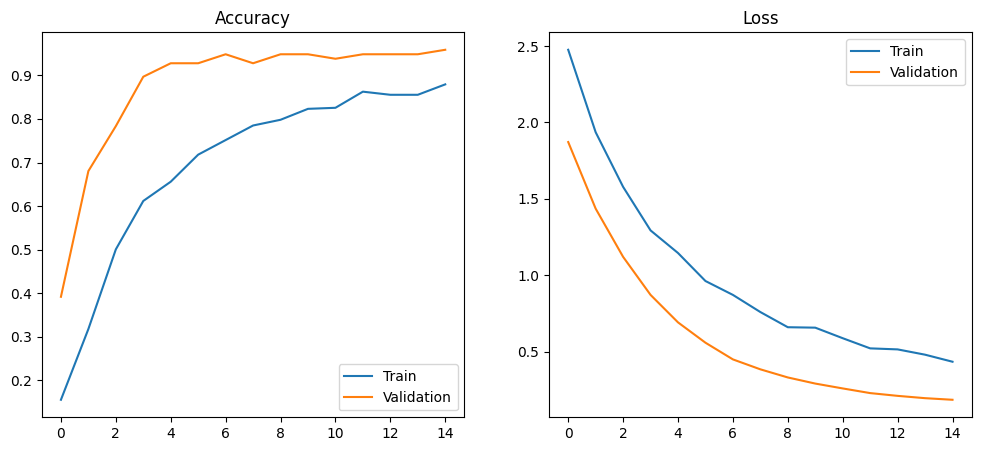

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()

SIMPAN MODEL

In [ ]:
model.save("/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/model_klasifikasi_buah_mobilenetv2.h5")
print("Model tersimpan di Google Drive")

Model tersimpan di Google Drive


In [ ]:
model.save("/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/model_klasifikasi_buah_mobilenetv2.keras")
print("Model tersimpan di Google Drive")

Model tersimpan di Google Drive


DEMO PREDIKSI

In [ ]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_random_images(test_dir, num_images=5):
    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    # ambil semua path gambar
    image_paths = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_name))

    # ambil random
    selected_images = random.sample(image_paths, num_images)

    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(selected_images):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array, verbose=0)
        class_idx = np.argmax(pred)
        confidence = np.max(pred) * 100

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediksi:\n{class_labels[class_idx]}\n({confidence:.1f}%)")

    plt.show()

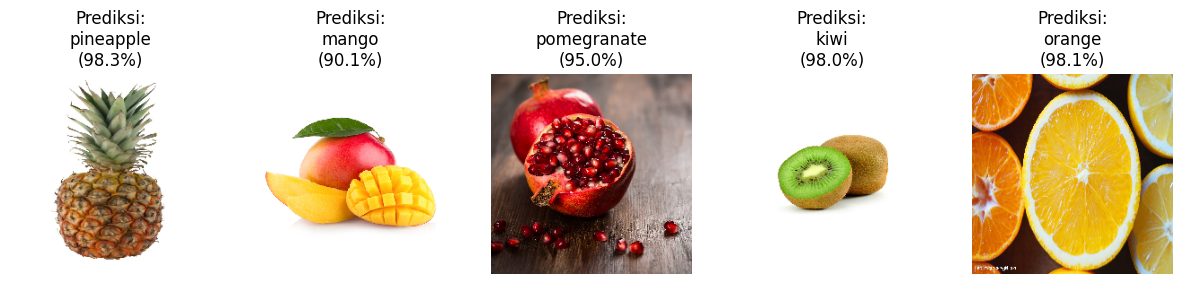

In [ ]:
predict_random_images("/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/dataset/test", num_images=5)

In [ ]:
def predict_external_images(folder_path):
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    image_files = os.listdir(folder_path)

    plt.figure(figsize=(15, 5))

    for i, img_name in enumerate(image_files[:5]):
        img_path = os.path.join(folder_path, img_name)

        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array, verbose=0)
        class_idx = np.argmax(pred)
        confidence = np.max(pred) * 100

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{class_labels[class_idx]}\n({confidence:.1f}%)")

    plt.show()

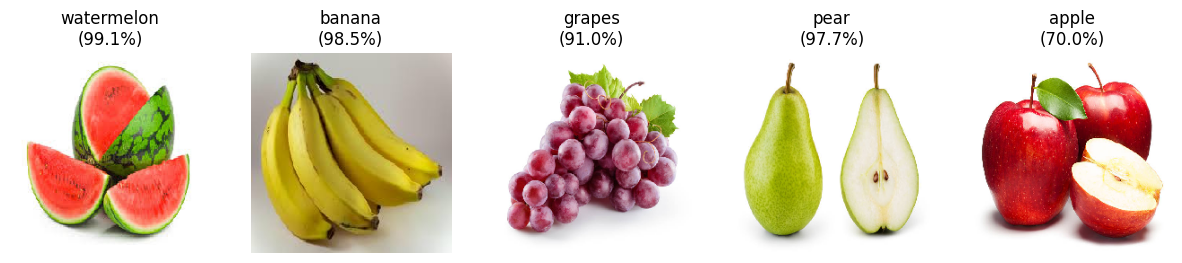

In [ ]:
predict_external_images("/content/drive/MyDrive/Semester5/AI_Lanjut/FP_Group7/demo_images")